In [1]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.6/dist-packages (0.9.0)
     |████████████████████████████████| 3.4MB 2.8MB/s 
  Found existing installation: tensorflow-datasets 2.1.0
    Uninstalling tensorflow-datasets-2.1.0:
      Successfully uninstalled tensorflow-datasets-2.1.0


In [2]:
#importing libraries

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

In [3]:
#loading and splitting our dataset into train_examples and validation_examples

(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete2MAHVW/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
#formatting each image to same size resolution of 224 as the mobilenet model uses that resolution

def format_images(image,label):
  #`hub` image module expect the data to be normalized into the range of[0,1]
  image=tf.image.resize(image, (Image_res, Image_res))/255.0
  return image,label

#getting the number of the examples 
num_examples=info.splits['train'].num_examples

Image_res=224
BATCH_SIZE=32

#train_batches=train_examples.cache().shuffle(num_examples//4).map(format_images).batch(BATCH_SIZE).prefetch(1)
train_batches=train_examples.shuffle(num_examples//4).map(format_images).batch(BATCH_SIZE).prefetch(1)
validation_batches=validation_examples.map(format_images).batch(BATCH_SIZE).prefetch(1)

In [5]:
# Transerfer learning with tensorflow_hub

URL="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor=hub.KerasLayer(URL,
                                 input_shape=(Image_res, Image_res, 3), 
                                 trainable=False)#freezinf the pre-trained model

In [6]:
#attaching a classification head/ output layer according to the number of output in our dataset

model = tf.keras.Sequential([
                             feature_extractor,
                             tf.keras.layers.Dense(2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:
#training the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # metrics=['accuracy'] #as there is a bug with using sparse 
              # categorical accuracy for now we will be using 
              # metrics='sparse_categorical_accuracy' instead of just 'accuracy'
              metrics=['sparse_categorical_accuracy']
              )

EPOCHS=3

history=model.fit(train_batches,
                  epochs=EPOCHS,
                  validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 56s 97ms/step - loss: 0.0525 - sparse_categorical_accuracy: 0.9822 - val_loss: 0.0317 - val_sparse_categorical_accuracy: 0.9886
Epoch 2/3
582/582 [==============================] - 55s 95ms/step - loss: 0.0315 - sparse_categorical_accuracy: 0.9897 - val_loss: 0.0305 - val_sparse_categorical_accuracy: 0.9897
Epoch 3/3
582/582 [==============================] - 55s 95ms/step - loss: 0.0246 - sparse_categorical_accuracy: 0.9917 - val_loss: 0.0419 - val_sparse_categorical_accuracy: 0.9867


In [8]:
# getting the names of classes in out dataset just checking T.T
class_names=np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [9]:
# creating image and label batches for prediction through our model
image_batch, label_batch = next(iter(train_batches.take(1)))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy() #removing size one dimenstions from our tensor
# predicted_ids = tf.argmax(predicted_batch, axis=-1)# using tf.argmax
# predicted_class_names = class_names[predicted_ids]
# predicted_class_names

predicted_id = np.argmax(predicted_batch, axis=-1)# using np.argmax
predicted_class_name = class_names[predicted_id]
predicted_class_name


array(['cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog',
       'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat',
       'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog',
       'cat', 'cat', 'cat', 'cat', 'dog'], dtype='<U3')

In [10]:
#true labels and predicted ones

print("Labels:  ", label_batch)
print("Predicted labels: ", predicted_id)

Labels:   [0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1]
Predicted labels:  [0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1]


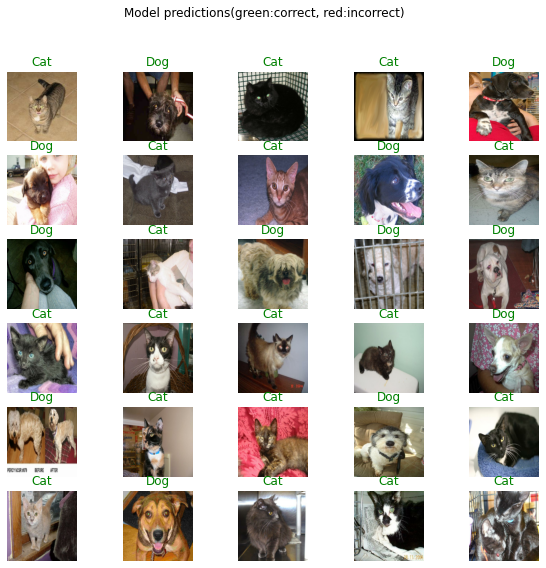

In [11]:
#plotting figures
plt.figure(figsize=(10,9))
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.imshow(image_batch[i])
  color = "green" if predicted_id[i] == label_batch[i] else "red"
  plt.title(predicted_class_name[i].title(), color=color)
  plt.axis('off')
_=plt.suptitle("Model predictions(green:correct, red:incorrect)")

In [12]:
# Saving model as keras .h5 model

t=time.time() # getting the current time this will be used in naming our model 
#so that we can have unique identities, just naming convention

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1598590992.h5


In [13]:
!ls

1598590992.h5  sample_data


In [14]:
# Loading the keras .h5 model

reloaded = tf.keras.models.load_model(
    export_path_keras,
    custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
# We can check that the reloaded and the previous model give the same result
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

#the difference in the output should be zero it verifies both outputs are same
(abs(result_batch-reloaded_result_batch)).max()

0.0

In [16]:
EPOCHS=3
history=reloaded.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 56s 96ms/step - loss: 0.0211 - sparse_categorical_accuracy: 0.9932 - val_loss: 0.0309 - val_sparse_categorical_accuracy: 0.9908
Epoch 2/3
582/582 [==============================] - 55s 95ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.0337 - val_sparse_categorical_accuracy: 0.9888
Epoch 3/3
582/582 [==============================] - 55s 95ms/step - loss: 0.0176 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.0326 - val_sparse_categorical_accuracy: 0.9890


In [17]:
#Exporting as a saved model
t = time.time()

export_path_sm="./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm) #saving our model and exporting it.
# checking in the file directory
!ls {export_path_sm}

./1598591180
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./1598591180/assets


INFO:tensorflow:Assets written to: ./1598591180/assets


assets	saved_model.pb	variables


In [18]:
#loading save model

reloaded_sm = tf.saved_model.load(export_path_sm)

In [19]:
#MAKING PREDICTION BASED ON reloaded_sm model

reload_sm_result_batch = reloaded_sm(image_batch, training = False).numpy()

#checking and comparing reults of both models

(abs(result_batch - reload_sm_result_batch)).max()

0.0

In [20]:
#Loading the SavedModel as Keras Model

t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

./1598591190
INFO:tensorflow:Assets written to: ./1598591190/assets


INFO:tensorflow:Assets written to: ./1598591190/assets


In [21]:
reloaded_sm_keras = tf.keras.models.load_model(
    export_path_sm,
    custom_objects={'KerasLayer':hub.KerasLayer})

reloaded_sm_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [23]:
# pridicting and comparing the models original and loaded
result_batch = model.predict(image_batch)
reload_sm_keras_result_batch = reloaded_sm_keras.predict(image_batch)

#comparing results if same or not
(abs(result_batch - reload_sm_keras_result_batch)).max()

0.0

In [24]:
#downloading our model
!zip -r model.zip {export_path_sm}

  adding: 1598591190/ (stored 0%)
  adding: 1598591190/assets/ (stored 0%)
  adding: 1598591190/saved_model.pb (deflated 92%)
  adding: 1598591190/variables/ (stored 0%)
  adding: 1598591190/variables/variables.index (deflated 78%)
  adding: 1598591190/variables/variables.data-00000-of-00001 (deflated 8%)


In [25]:
!ls

1598590992.h5  1598591180  1598591190  model.zip  sample_data


In [26]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>